<a href="https://colab.research.google.com/github/teja-1403/CODSOFT_1/blob/main/movie_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Genre Classification using Python**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Import necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import regex as re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
import warnings

warnings.filterwarnings('ignore')

**2. Loading and Exploring Datasets**

In [ ]:
train_data_path = '/content/drive/MyDrive/MGC/Genre Classification Dataset/train_data.txt'
test_data_path = '/content/drive/MyDrive/MGC/Genre Classification Dataset/test_data.txt'
test_solution_path = '/content/drive/MyDrive/MGC/Genre Classification Dataset/test_data_solution.txt'

train_data = pd.read_csv(train_data_path, delimiter=':::', names=['Title', 'Genre', 'Description'])
test_data = pd.read_csv(test_data_path, delimiter=':::', names=['Title', 'Description'])
test_sol = pd.read_csv(test_solution_path, delimiter=':::', names=['Title', 'Genre', 'Description'])

In [ ]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 54200 entries, 1 to 54200
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54200 non-null  object
 1   Description  54200 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


**3. Data Preprocessing**

In [ ]:
# Check for null values
train_data.isnull().sum()
test_data.isnull().sum()

,0
Title,0
Description,0


In [ ]:
columns = ['Title', 'Description', 'Genre']
train_data = train_data[columns]
train_data.head()
test_data.head()

,Title,Description
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


In [ ]:
train_data['Genre'].nunique()

train_data['Genre'].unique()

# No. of movies in each genre
train_data['Genre'].value_counts()

,count
Genre,
drama,13613
documentary,13096
comedy,7447
short,5073
horror,2204
thriller,1591
action,1315
western,1032
reality-tv,884


**4. Movie Genre Plot**

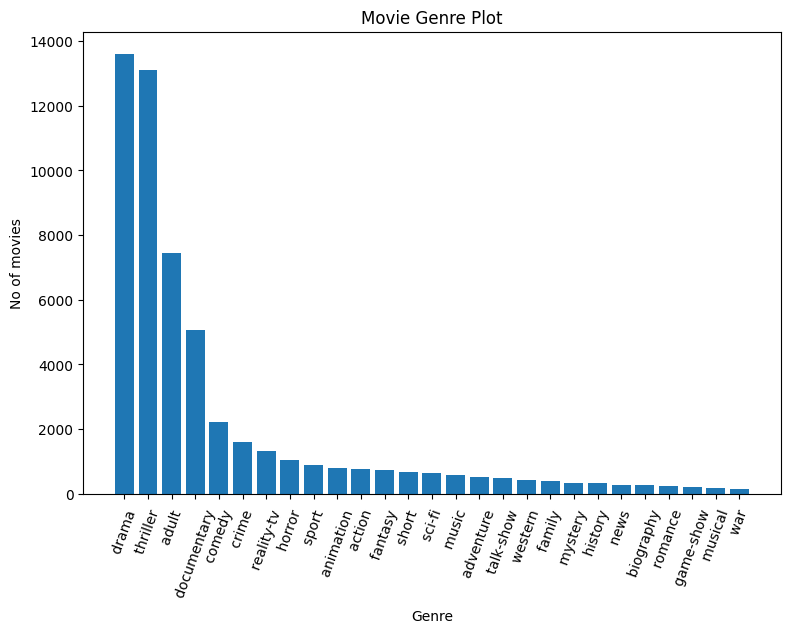

In [ ]:
plt.figure(figsize=(9,6))
plt.bar(train_data['Genre'].unique(), train_data['Genre'].value_counts())
plt.title('Movie Genre Plot')
plt.xlabel('Genre')
plt.ylabel('No of movies')
plt.xticks(rotation=70)
plt.show()

In [ ]:
x_train = train_data.iloc[:, 1].values
y_train = train_data.iloc[:, -1].values
x_test = test_data.iloc[:, -1].values

**5. Text Preprocessing**

In [ ]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def process_text(text):
    sentence = text.lower()
    # Removing username
    sentence = re.sub(r'@[a-zA-Z0-9_.]+','',sentence)
    # Removing URLs
    sentence = re.sub(r"https?://\S+|www\.\S+",'',sentence)
    # Character normalization
    sentence = re.sub(r"([a-zA-Z])\1{2,}", r'\1', sentence)
    # Removing punctuations
    sentence = re.sub(r'[^\w\s]','',sentence)
    # Removing stopwords & converting to lowercase
    english_stop = stopwords.words('english')
    sentence = ' '.join([word for word in sentence.split() if word not in english_stop])
    # Performing word tokenization
    sentence = word_tokenize(sentence)
    # Performing lemmatization
    lemmatizer = WordNetLemmatizer()
    sentence = ' '.join([lemmatizer.lemmatize(word) for word in sentence])
    return sentence

In [ ]:
x_train = [process_text(desc) for desc in x_train]
x_test = [process_text(desc) for desc in x_test]

In [ ]:
x_train_low = [desc.split() for desc in x_train]
x_test_low = [desc.split() for desc in x_test]

In [ ]:
# Creating a vocabulary
vocab = set()

for desc in x_train_low:
    for word in desc:
        vocab.add(word)
print("Size of vocabulary: ", len(vocab))

Size of vocabulary:  139848


**6. TF-IDF Vectorization**

In [ ]:
tf_idf = TfidfVectorizer(max_features=5000)
train_vector = tf_idf.fit_transform(x_train)
test_vector = tf_idf.transform(x_test)

**7. Word2Vec Model**

In [ ]:
model = Word2Vec(sentences=x_train_low, vector_size=100, epochs=5, workers=5)
words_in_model = set(model.wv.index_to_key)

In [ ]:
# Check if all the words in the sentence are part of the vocabulary of the model or not
def get_word_vector(sentence):
    valid_words = [word for word in sentence if word in words_in_model]
    if valid_words:
        return model.wv[valid_words].sum(axis=0)
    else:
        return np.zeros(100)

In [ ]:
# Creating train and test data word vectors
train_wv = [get_word_vector(sentence) for sentence in x_train_low]
test_wv = [get_word_vector(sentence) for sentence in x_test_low]

**8. Model Training using TF-IDF vectors**

In [ ]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(train_vector, y_train)
log_pred = log_reg.predict(train_vector)
print('Logistic Regression Accuracy Score (TF-IDF): ', round(accuracy_score(log_pred, y_train), 2))

# Naive Bayes
nb = GaussianNB()
nb.fit(train_vector.toarray(), y_train)
nb_pred = nb.predict(train_vector.toarray())
print('Naive Bayes Accuracy Score (TF-IDF): ', round(accuracy_score(nb_pred, y_train), 2))

Logistic Regression Accuracy Score (TF-IDF):  0.66
Naive Bayes Accuracy Score (TF-IDF):  0.36


**9. Model Training using Word2Vec word embeddings**

In [ ]:
# Logistic Regression on Word2Vec
log_r = LogisticRegression()
log_r.fit(train_wv, y_train)
log_p = log_r.predict(train_wv)
print('Logistic Regression Accuracy Score (Word2Vec): ', round(accuracy_score(log_p, y_train), 2))

# Naive Bayes on Word2Vec
nb = GaussianNB()
nb.fit(train_wv, y_train)
nb_pred = nb.predict(train_wv)
print('Naive Bayes Accuracy Score (Word2Vec): ', round(accuracy_score(nb_pred, y_train), 2))

Logistic Regression Accuracy Score (Word2Vec):  0.54
Naive Bayes Accuracy Score (Word2Vec):  0.16


**10. Model evaluation**

In [ ]:
# TF-IDF vector representations gives better results compared to Word2Vec word embeddings.
test_pred = log_reg.predict(test_vector)
test_sol['Predicted'] = test_pred
test_sol.head()

total_movies = len(test_sol)
correct_predictions = 0
for movie in range(1, total_movies+1):
    if test_sol['Genre'][movie] == test_sol['Predicted'][movie]:
        correct_predictions += 1

print("Total number of predictions: ", total_movies)
print("Number of correct predictions: ", correct_predictions)
print("Percentage of correct predictions using Logistic Regression model (TF-IDF): ", round((correct_predictions / total_movies) * 100, 0), "%")

Total number of predictions:  54200
Number of correct predictions:  31667
Percentage of correct predictions using Logistic Regression model (TF-IDF):  58.0 %
